In [1]:
%autosave 0

Autosave disabled


In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso, LassoCV, LinearRegression
from sklearn.model_selection import KFold
from utilities import cal_score

In [3]:
stack_idx = '12'
models = '1-18,20'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = True

### Read CV predictions and test

In [4]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [5]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]


In [6]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [7]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [8]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [9]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [10]:
print('CV predictions:')
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
No. 0 file: model-01-lgb-cv.csv
No. 1 file: model-02-keras-search-cv.csv
No. 2 file: model-03-lgb-feats-selection-cv.csv
No. 3 file: model-04-lgb-PCA-cv.csv
No. 4 file: model-05-lgb-wo-per-area-cv.csv
No. 5 file: model-06-lgb-lr0.001-cv.csv
No. 6 file: model-07-keras-embedding-cv.csv
No. 7 file: model-08-keras-search-long-cv.csv
No. 8 file: model-09-lgb-feats-selection-75-cv.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-cv.csv
No. 10 file: model-11-rf-cv.csv
No. 11 file: model-12-predict-keras-search-prelu-cv.csv
No. 12 file: model-13-predict-keras-he_uni-cv.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
No. 17 file: model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
No. 18 file: model-20-lgb-lr-0.0008-mix5-cv.csv


In [11]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-11-rf-test-one.csv
No. 11 file: model-12-predict-keras-search-prelu-test-kfold.csv
No. 12 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv
No. 17 file: model-18-l

In [12]:
cv.head()

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_17,log_parea_pred_17,pred_18,log_pred_18,log_parea_pred_18,pred_20,log_pred_20,log_parea_pred_20,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.392766,12.163663,6.631879e+05,13.404815,12.175712,6.385893e+05,13.367018,12.137915,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.956603,13.560036,3.092403e+06,14.944459,13.547892,3.171011e+06,14.969561,13.572994,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.096597,14.376642,9.773138e+06,16.095148,14.375193,9.802951e+06,16.098194,14.378239,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.357815,13.750469,1.266263e+07,16.354166,13.746819,1.266383e+07,16.354260,13.746914,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.919882,12.374856,1.128016e+06,13.935971,12.390946,1.124958e+06,13.933257,12.388231,13.544637,11.999613


In [13]:
test.head()

,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_16,pred_17,log_pred_17,log_parea_pred_17,pred_18,log_pred_18,log_parea_pred_18,pred_20,log_pred_20,log_parea_pred_20
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.217310,1.449905e+07,16.489594,15.260487,1.396801e+07,16.452280,15.223173,1.478805e+07,16.509330,15.280223
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.136639,3.917960e+06,15.181082,13.136463,3.908782e+06,15.178737,13.134118,3.918591e+06,15.181243,13.136624
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.690042,1.063343e+07,16.179513,13.680493,1.073427e+07,16.188952,13.689931,1.069408e+07,16.185201,13.686181
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.808737,6.119193e+06,15.626941,14.815009,6.084894e+06,15.621320,14.809388,6.033528e+06,15.612843,14.800910
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.125206,1.084776e+06,13.896885,12.136623,1.087941e+06,13.899798,12.139536,1.089268e+06,13.901017,12.140755


### Check models scores

In [14]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-12 5486.856963
12 model-13 5506.858055
13 model-14 5908.873901
14 model-15 5900.873836
15 model-16 5907.874126
16 model-17 5905.874165
17 model-18 5908.874297
18 model-20 5908.874040


### Make Xy

In [15]:
if is_per_area:
    X = cv[['log_parea_pred_{}'.format(idx) for idx in idx_models]]
else:
    X = cv[['log_pred_{}'.format(idx) for idx in idx_models]]

if is_per_area:
    y = cv['log_parea_total_price']
else:
    y = cv['log_total_price']

### start regression

In [16]:
#reg = LassoCV(alphas=[0]+list(np.logspace(-4, 3, 7)), max_iter=100000, tol=1e-6, n_jobs=-1)
#reg.fit(X, y)

#print(reg.alpha_)
#print(reg.mse_path_)
#print(reg.coef_, reg.intercept_)

In [17]:
#for a in [0]+list(np.logspace(-4, 3, 7)):
#    reg_single = Lasso(alpha=a, max_iter=100000, tol=1e-6)
#    reg_single.fit(X, y)
#    print(reg_single.coef_, reg.intercept_)
#    print(reg_single.score(X,y))

In [18]:
alphas = [0, 0.00001, 0.00002, 0.00005, 0.00008, 0.0001, 0.0002, 0.0005, 0.0008, 0.001, 0.002, 0.005, 0.008, 0.01, 0.02]
gsearch = {}

folds = KFold(n_splits=3, shuffle=True, random_state=1208)
for i_fold, (itrain, ival) in enumerate(folds.split(X)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    X_train = X.iloc[itrain]
    X_val = X.iloc[ival]
    y_train = y.iloc[itrain]
    y_val = y.iloc[ival]
    
    # random sample - grid search
    for a in alphas:
        if a == 0:
            reg_single = LinearRegression()
        else:
            reg_single = Lasso(alpha=a, max_iter=100000, tol=1e-6)
        reg_single.fit(X_train, y_train)
        
        y_pred = reg_single.predict(X_val)
        if is_per_area:
            y_pred_final = np.expm1(y_pred) * cv.iloc[ival]['building_area']
            y_true_final = np.expm1(y_val) * cv.iloc[ival]['building_area']
        else:
            y_pred_final = np.expm1(y_pred)
            y_true_final = np.expm1(y_val)
        score = cal_score(y_true_final, y_pred_final)

        print('alpha, score:', a, score)
        gsearch[a] = gsearch.get(a, []) + [score]

results = [[key, np.mean(value), value] for key, value, in gsearch.items()]
results.sort(key= lambda x: x[1], reverse=True)
for item in results:
    print(item)

==== Fold 1 ====
alpha, score: 0 5988.874925883665
alpha, score: 1e-05 6006.874981964796
alpha, score: 2e-05 6000.874998567296
alpha, score: 5e-05 5990.874998004594
alpha, score: 8e-05 5989.875005514873
alpha, score: 0.0001 5989.875011457269
alpha, score: 0.0002 5998.875033207817
alpha, score: 0.0005 5994.875010316453
alpha, score: 0.0008 5982.874852824211
alpha, score: 0.001 5983.874817208539
alpha, score: 0.002 5974.874800278421
alpha, score: 0.005 5973.874673001742
alpha, score: 0.008 5976.874412322362
alpha, score: 0.01 5979.8741762193
alpha, score: 0.02 5923.872443083321
==== Fold 2 ====
alpha, score: 0 5920.875670239553
alpha, score: 1e-05 5928.875766334644
alpha, score: 2e-05 5932.875798410817
alpha, score: 5e-05 5932.8758452862985
alpha, score: 8e-05 5933.87585421224
alpha, score: 0.0001 5936.8758639085545
alpha, score: 0.0002 5934.875905682906
alpha, score: 0.0005 5934.8759561153
alpha, score: 0.0008 5936.875889109147
alpha, score: 0.001 5928.875826214518
alpha, score: 0.002 5

In [19]:
alpha_set = results[0][0]
print(alpha_set)
if alpha_set == 0:
    reg = LinearRegression()
else:
    reg = Lasso(alpha=alpha_set, max_iter=1000000, tol=1e-6)
reg.fit(X, y)

0.0005


Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-06, warm_start=False)

In [20]:
print(reg.coef_, reg.intercept_)

[ 0.          0.04824702  0.03149388  0.          0.20967279  0.
  0.10272522  0.02126639  0.          0.         -0.05153329  0.03247667
  0.00180778  0.05252841  0.          0.10547759  0.          0.
  0.45009298] -0.056145449213090615


### Calculate cv score

In [21]:
cv_pred_final = np.zeros(X.shape[0])
for i, col in enumerate(X):
    cv_pred_final = cv_pred_final + X[col] * reg.coef_[i]
cv_pred_final = cv_pred_final + reg.intercept_

if is_per_area:
    cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    cv_true_final = np.expm1(y) * cv['building_area']
else:
    cv_pred_final = np.expm1(cv_pred_final)
    cv_true_final = np.expm1(y)

In [22]:
pd.DataFrame({'a':cv_true_final,'b':cv_pred_final}).head()

,a,b
0,6.476038e+05,6.337861e+05
1,3.321452e+06,3.144548e+06
2,9.570885e+06,9.796018e+06
3,1.421501e+07,1.272680e+07
4,7.627120e+05,1.259984e+06


In [23]:
cal_score(cv_true_final, cv_pred_final)

5949.875414515889

In [24]:
y_pred_cv = reg.predict(X)
y_pred_final = np.expm1(y_pred_cv) * cv['building_area']
y_true_final = cv['total_price']
print(cal_score(y_true_final, y_pred_final))

5949.875414515889


### Compute submission

In [25]:
if is_per_area:
    col_prefix = 'log_parea_pred'
else:
    col_prefix = 'log_pred'

test_pred_final = pd.DataFrame({'building_id': test['building_id'], 'total_price': np.zeros(test.shape[0])})

for i, idx in enumerate(idx_models):
    test_pred_final['total_price'] = test_pred_final['total_price'] + test[f'{col_prefix}_{idx}'] * reg.coef_[i]
test_pred_final['total_price'] = test_pred_final['total_price'] + reg.intercept_

if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

In [26]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


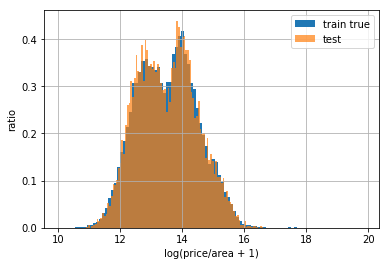

In [27]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

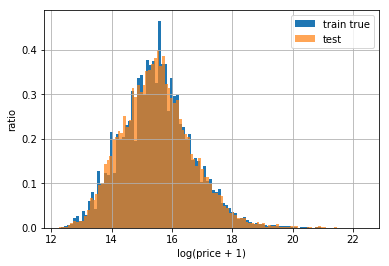

In [28]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

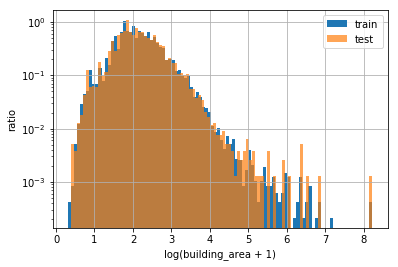

In [29]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

In [30]:
if is_per_area:
    test_pred_final.to_csv('output/stack_parea_{}_{}.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final.to_csv('output/stack_{}_{}.csv'.format(stack_idx, models), index=False)

In [31]:
#a= pd.read_csv('output/model-03-lgb-feats-selection-cv.csv')
#b= pd.read_csv('output/model-03-lgb-feats-selection-test-one.csv')

In [32]:
#a.rename(columns={'building_id':'id','total_price_predict':'target'}).to_csv('opt-pred3.csv',index=False)
#b.rename(columns={'building_id':'id','total_price':'target'}).to_csv('opt-test3.csv',index=False)